## Implementation of Transformer-Based Few Shot Learning

### ECE590 Homework assignment 6
Name: Javier Cervantes

net id: jc1010

We are interested in running experiments with Transformers applied to functional data. There are three papers we are focusing on, with associated code:

• For the linear attention examples, we are focused on this paper: https://arxiv.org/abs/2212.07677 and the GitHub for the code is here: https://github.com/google-research/self-organising-systems/tree/master/transformers_learn_icl_by_gd

• For the examples with softmax attention (traditional Transformer design), we are interested in this paper: https://arxiv.org/abs/2208.01066 and the GitHub for the code is here: https://github.com/dtsip/in-context-learning

• The MAML GitHub may also be useful: https://github.com/cbfinn/maml . For this homework, it is ok to use/modify the above code to implement experiments.

Consider the following process for generating contextual data for a linear model: weights $w_m \in \mathbb{R}^{10}$ are drawn for context $m$ as $w_m \sim \mathcal{N}(\mu, I_{10})$ where $\mu \in \mathbb{R}^{10}$ is a fixed mean vector. Covariates $x_i \in \mathbb{R}^{10}$ are drawn as $x_i \sim \mathcal{N}(0, I_{10})$. For contextual data $\mathcal{C}_m$ draw one weight vector $w_m$ as above. For a context of length $N$ draw $x_{m,i}, i = 1, \ldots, N$ as above, and for each $x_{m, i}$ constitute a corresponding $y_{m, i} = w_m^T x_{m, i}$. The contextual data so drawn are represented as $\mathcal{C}_m = (x_{m, 1}, y_{m, 1}, \ldots, x_{m, N}, y_{m, N})$. Finally, draw a query associated with $\mathcal{C}_m, x_{m, N+1}$, and the model is to predict $y_{m, N+1} $ given $x_{m, N+1}$ and $\mathcal{C}_m$. In the following experiments set $\mu$ as a vector of all values equal to one: $\mu = (1, \ldots, 1)^T$. In all experiments, consider the number of pairs in the context as $N = 5, \ldots, 20$ (examine performance of the methods over this range of $N$).

a) Perform in-context learning based on MAML, and assume a linear model $f_w(x) = w^T x$, with model parameters $w$. Use MAML to learn good initialization parameters $w_0$, based on $\mathcal{C}_m = (x_{m, 1}, y_{m, 1}, \ldots, x_{m, N}, y_{m, N})$ for $m = 1, \ldots, M$, then apply the model to predict $y_{M+1, N+1}$ for $\mathcal{C}_{M+1} = (x_{M+1, 1}, y_{M+1, 1}, \ldots, x_{M+1, N}, y_{M+1, N}, y_{M+1, N+1})$. Show results for various sizes of $M$ and $N$.

> I shall begin by training the model using M = 10, 15 and N = 5, 10, 15, 20. I will then proceed to evaluate the learned model on a new, unseen task. To compare between values of M and N, I will use the mean squared error as a metric, such that, I will compare the `true y` with the `predicted y` of each model after performing 10 steps of fine-tuning. 

In [1]:
from maml_pytorch import maml
import torch
import numpy as np


def train(
    functional_class="linear",
    linear_bias=False,
    bias_var=1,
    M=10,
    N=10,
    dimension=10,
    device="cpu",
):
    # xavier initialization of parameters
    params = [
        torch.rand(40, dimension, device=device)
        .uniform_(-np.sqrt(6.0 / 41), np.sqrt(6.0 / 41))
        .requires_grad_(),
        torch.zeros(40, device=device).requires_grad_(),
        torch.rand(40, 40, device=device)
        .uniform_(-np.sqrt(6.0 / 80), np.sqrt(6.0 / 80))
        .requires_grad_(),
        torch.zeros(40, device=device).requires_grad_(),
        torch.rand(1, 40, device=device)
        .uniform_(-np.sqrt(6.0 / 41), np.sqrt(6.0 / 41))
        .requires_grad_(),
        torch.zeros(1, device=device).requires_grad_(),
    ]

    device = "cpu"
    meta_optimizer = torch.optim.Adam(params, lr=1e-3)

    # train the model
    training_loss = maml(
        p_model=params,
        meta_optimizer=meta_optimizer,
        inner_training_steps=1,
        nb_epochs=70_000,
        N=N,
        alpha=1e-3,
        M=M,
        functional_class=functional_class,
        linear_bias=linear_bias,
        bias_var=bias_var,
        device=device,
        dimension=dimension,
    )

    return training_loss

In [ ]:
device = "cpu"
functional_class = "linear"
linear_bias = False
bias_var = 1
dimension = 10
M = 10
N = 10

training_loss = train(
    functional_class=functional_class,
    linear_bias=linear_bias,
    bias_var=bias_var,
    M=M,
    N=N,
    dimension=dimension,
    device=device,
)

In [47]:
from maml_pytorch import sample_task, perform_k_training_steps, mlp
import torch


def test(dimension, device, functional_class, linear_bias, bias_var, M, N):
    # load a model
    if linear_bias:
        model = torch.load(f"models/MAML_M{M}_N{N}_dim{dimension}_bias{bias_var}.pth")
    else:
        model = torch.load(f"models/MAML_M{M}_N{N}_dim{dimension}.pth")

    params = model["model_state_dict"]

    # generate x and y values against which to evaluate the model
    x_single_dim = torch.linspace(-2, 2, 50, device=device)
    x = x_single_dim.repeat(dimension, 1).t().contiguous()
    # y_pre_update = mlp(x[..., None], params)
    y_pre_update = torch.stack([mlp(x_i, params) for x_i in x])

    # New task
    task = sample_task(
        functional_class=functional_class,
        linear_bias=linear_bias,
        bias_var=bias_var,
        dimension=dimension,
    )

    if functional_class == "linear":
        y_ground_truth = torch.matmul(x, task.slope) + task.bias
    elif functional_class == "sinusoid":
        y_ground_truth = task.a * torch.sin(x + task.b)

    # Fine-tuning, 10 gradient steps
    new_params = perform_k_training_steps(
        params=[p.clone() for p in params],
        task=task,
        N=N,
        inner_training_steps=10,
        alpha=1e-3,
        functional_class=functional_class,
        device=device,
    )

    # After 10 gradient steps
    y = torch.stack([mlp(x_i, new_params) for x_i in x])
    loss_fn = torch.nn.MSELoss()
    loss = loss_fn(y, y_ground_truth)

    return x, y_pre_update, y_ground_truth, y, loss

> Now that I have defined my evaluation process, I can proceed to evaluate each one of the model's I've trained. What follows is a heatmap that represents the mean squared error of each model, where the x-axis represents the number of pairs in the context and the y-axis represents the number of tasks used to train the model.

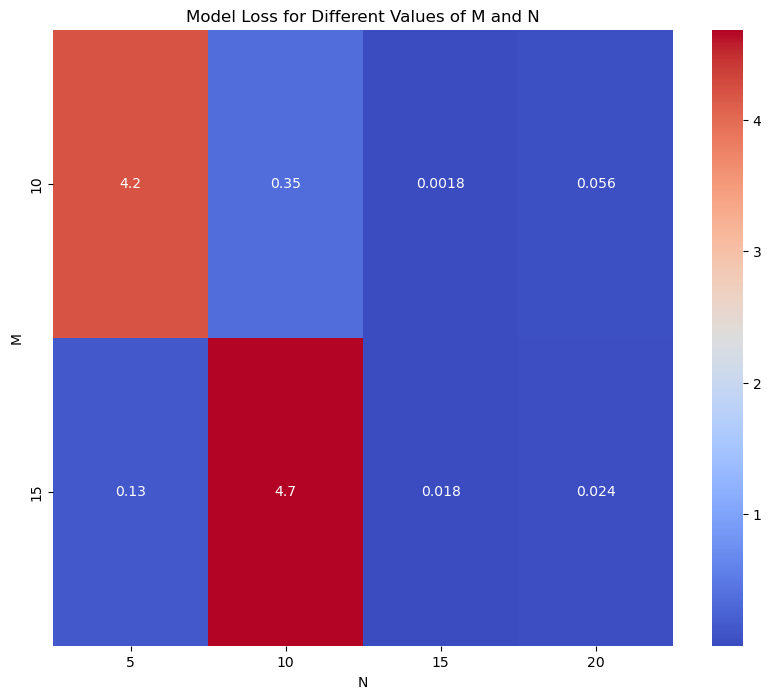

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# model assessment
dimension = 10
device = "cpu"
functional_class = "linear"
linear_bias = False
bias_var = 1
M = [10, 15]
N = [5, 10, 15, 20]


# Initialize a 2D list to store the losses
losses = []

# Iterate over each combination of M and N
for m in M:
    row = []
    for n in N:
        _, _, _, _, loss = test(
            dimension=dimension,
            device=device,
            functional_class=functional_class,
            linear_bias=linear_bias,
            bias_var=bias_var,
            M=m,
            N=n,
        )
        row.append(loss.item())  # Convert the loss from a tensor to a Python number
    losses.append(row)

# Convert the 2D list of losses to a tensor
losses = torch.tensor(losses)

# Generate a heatmap from the 2D tensor of losses
plt.figure(figsize=(10, 8))
sns.heatmap(losses, annot=True, xticklabels=N, yticklabels=M, cmap="coolwarm")
plt.xlabel("N")
plt.ylabel("M")
plt.title("Model Loss for Different Values of M and N")
plt.show()


> These are somewhat surprising results in the sense that the loss increased when jumping from 15 to 20 observations in the context for both levels of `M`. Similarly, there isn't a very clear relationship between the loss and the number of tasks used to train the model.

b) Add noise to the observed $y_{m, i}$ , where now it is $y_{m, i} = w_m^T x_{m, i} + \epsilon_{m, i}$, where $\epsilon_{m, i} \sim \mathcal{N}(0, \sigma^2)$. Examine different sizes of $\sigma^2$ and examine the robustness of MAML to such noise-induced model mismatch.

> I will now train the model using M = 10, N = 10 but with different levels of noise. I will use $\sigma^2 = 0.5, 1.0, 2.0$ to train the model and then compare to the results observed in the previous exercise. 

In [ ]:
device = "cpu"
functional_class = "linear"
linear_bias = False
bias_var = 1
dimension = 10
M = 10
N = 10

training_loss = train(
    functional_class=functional_class,
    linear_bias=linear_bias,
    bias_var=bias_var,
    M=M,
    N=N,
    dimension=dimension,
    device=device,
)


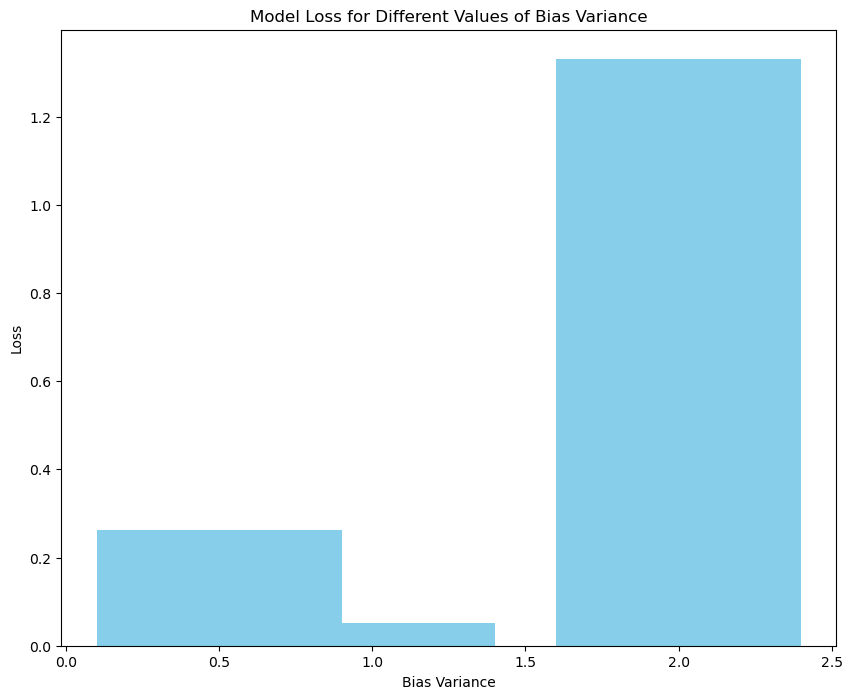

In [48]:
# model assessment
dimension = 10
device = "cpu"
functional_class = "linear"
M = 10
N = 10
linear_bias = True
bias_var = [0.5, 1, 2]

# Initialize a list to store the losses
losses = []

# Iterate over each value of bias_var
for b in bias_var:
    _, _, _, _, loss = test(
        dimension=dimension,
        device=device,
        functional_class=functional_class,
        linear_bias=linear_bias,
        bias_var=b,
        M=M,
        N=N,
    )
    losses.append(loss.item())  # Convert the loss from a tensor to a Python number

# Convert the list of losses to a tensor
losses = torch.tensor(losses)

# Generate a bar plot from the tensor of losses
plt.figure(figsize=(10, 8))
plt.bar(bias_var, losses, color="skyblue")
plt.xlabel("Bias Variance")

plt.ylabel("Loss")
plt.title("Model Loss for Different Values of Bias Variance")
plt.show()


> Remember the M=10, N=10 model trained without bias had a mean squared error of approximately 0.35. From the bar plot above, we can observe that, for bias with variance 0.5 and 1, the mean squared error is below that of the model trained without bias. However, when the variance is increased to 2, the mean squared error is higher than that of the model trained without bias. 
>
> There is quite a bit of variability in the results, but from the bar plot above, MAML seems to be robust to noise.

c) For (a) above, rather than doing MAML, use a Transformer with linear attention. As in https://arxiv.org/abs/2212.07677, show results as a function of $M$ and $N$, and compare your results to MAML, and also to ordinary least squares (OLS). Do the linear-attention Transformer two ways: 

1. based on the *designed* Transformer parameters 

2.  also when the Transformer parameters are learned, based on ${\mathcal{C}_m}_{m=1, M}$ 

Compare the results of the Transformer with designed and learned parameters. There are similar experiments in the paper, that you should design your results on. Consider performance with and without noise $\epsilon_{m,i}$ added to the observed outcomes, like in (b).

Now consider contextual data $\mathcal{C}_m = (x_{m, 1}, y_{m, 1}, \ldots, x_{m, N}, y_{m, N})$ where in each case $y_{m, i} = f_{w_m}(x_{m, i}) = w_m^T x_{m,i}$, where each $w_m \sim \mathcal{N}(\mathbf{0}_d, I_d)$, where $d = 10$. This is as above, but now the manner with which $x_{m,i}$ are drawn is different: Consider two 10-dimensional real-valued vectors: $v=(v_1, \ldots, v_{10})^T$ and $u=(u_1, \ldots, u_{10})^T$, where $v_j = cos(\frac{j \pi}{5})$ and $u_j = sin(\frac{j \pi}{5})$, for $j = 1, \ldots, 10$. Each $x_{m,i} = \alpha v + \beta u + \epsilon$, where $\alpha \sim \mathcal{N}(0, 1)$, $\beta \sim \mathcal{N}(0, 1)$, and $\epsilon = (\epsilon_1, \ldots, \epsilon_{10})^T$ , with $\epsilon_j \sim \mathcal{N}(0, \frac{1}{100})$. Note, what this says is that each $x_{m,i} \in \mathbb{R}^{10} $ is expressed as a randomly scaled sum of two factors, with the two factors represented by $u$ and $v$ (with respective random weights $\alpha$ and $\beta$), and the vector $\epsilon$ represents a small amount of additive noise.

d) What is the covariance of the data $x\in \mathbb{R}^{10}$ drawn in the manner specified above?

e) For data generated as above, use the designed Transformer with linear attention to perform few-shot learning on new contextual data $\mathcal{C}_{M+1} = (x_{m+1,1}, y_{M+1,1}, \ldots , x_{M+1, N}, y_{M+1, N}, x_{M+1, N+1})$, and compare that to the performance of a linear Transformer trained on ${\mathcal{C}_m}_{m=1,M}$ (in the latter, you *learn* the
Transformer parameters via ${\mathcal{C}_m}_{m=1,M} $ ). Consider performance for various settings of $M$, for the trained model. For this problem, pay special attention to the GD++ framework in https://arxiv.org/abs/2212.07677; we will also discuss this in class.

f) Repeat the experiments in (c)-(d) using softmax attention and the full Transformer, as in https://arxiv.org/abs/2208.01066; in this case we do not make the linear-attention assumption and follow the framework in the referenced paper (and that we discussed in class). Compare the performance of the learned Transformer with softmax attention to what you got in (e) with linear attention. Which method works better, in the sense of model accuracy as a function of Transformer depth?